## Stable Diffusion XL 1.0 on DJL

- model hub : https://huggingface.co/stabilityai/stable-diffusion-xl-base-1.0
- VAE model : https://huggingface.co/madebyollin/sdxl-vae-fp16-fix

### Issues

- decoding issue : https://github.com/huggingface/diffusers/issues/1988
- black image issue : https://github.com/huggingface/diffusers/issues/4325


In [1]:
import boto3
import sagemaker
from sagemaker.utils import name_from_base
from sagemaker import image_uris

In [2]:
llm_engine = "deepspeed"
# llm_engine = "fastertransformer"

In [3]:
sagemaker_session = sagemaker.Session()
role = sagemaker.get_execution_role()
sm_client = sagemaker_session.sagemaker_client
sm_runtime_client = sagemaker_session.sagemaker_runtime_client
s3_client = boto3.client('s3')

In [4]:
framework_name = f"djl-{llm_engine}"
inference_image_uri = image_uris.retrieve(
    framework=framework_name, region=sagemaker_session.boto_session.region_name, version="0.22.1"
)

print(f"Inference container uri: {inference_image_uri}")

Inference container uri: 763104351884.dkr.ecr.us-west-2.amazonaws.com/djl-inference:0.22.1-deepspeed0.8.3-cu118


In [35]:
s3_target = f"s3://{sagemaker_session.default_bucket()}/llm/sdxl10-base/code/"
print(s3_target)

s3://sagemaker-us-west-2-723597067299/llm/sdxl10-base/code/


In [36]:
!rm -rf sdxl10-src.tar.gz
!tar zcvf sdxl10-src.tar.gz sdxl10-src --exclude ".ipynb_checkpoints" --exclude "__pycache__"
!aws s3 cp sdxl10-src.tar.gz {s3_target}

sdxl10-src/
sdxl10-src/model.py
sdxl10-src/run_sd_local.py
sdxl10-src/requirements.txt
sdxl10-src/serving.properties
upload: ./sdxl10-src.tar.gz to s3://sagemaker-us-west-2-723597067299/llm/sdxl10-base/code/sdxl10-src.tar.gz


In [37]:
model_uri = f"{s3_target}sdxl10-src.tar.gz"
print(model_uri)

s3://sagemaker-us-west-2-723597067299/llm/sdxl10-base/code/sdxl10-src.tar.gz


In [38]:
model_name = name_from_base(f"sdxl10-base-djl")
print(model_name)

create_model_response = sm_client.create_model(
    ModelName=model_name,
    ExecutionRoleArn=role,
    PrimaryContainer={"Image": inference_image_uri, "ModelDataUrl": model_uri},
)
model_arn = create_model_response["ModelArn"]

print(f"Created Model: {model_arn}")

sdxl10-base-djl-2023-08-01-07-39-30-639
Created Model: arn:aws:sagemaker:us-west-2:723597067299:model/sdxl10-base-djl-2023-08-01-07-39-30-639


In [39]:
default_bucket = sagemaker_session.default_bucket()
async_output_uri = f"s3://{default_bucket}/llm/outputs/{model_name}/"
print(async_output_uri)

s3://sagemaker-us-west-2-723597067299/llm/outputs/sdxl10-base-djl-2023-08-01-07-39-30-639/


In [40]:
instance_type = "ml.g5.2xlarge"
# instance_type = "ml.g5.xlarge"
# instance_type = "ml.g4dn.xlarge"

endpoint_config_name = f"{model_name}-async-config"
endpoint_name = f"{model_name}-async-endpoint"

endpoint_config_response = sm_client.create_endpoint_config(
    EndpointConfigName=endpoint_config_name,
    ProductionVariants=[
        {
            "VariantName": "variant1",
            "ModelName": model_name,
            "InstanceType": instance_type,
            "InitialInstanceCount": 1,
            "ContainerStartupHealthCheckTimeoutInSeconds": 600,
        },
    ],
    AsyncInferenceConfig={
        "OutputConfig": {
            "S3OutputPath": async_output_uri,
        },
        "ClientConfig": {
            "MaxConcurrentInvocationsPerInstance": 1
        }
    }
)
print(endpoint_config_response)

{'EndpointConfigArn': 'arn:aws:sagemaker:us-west-2:723597067299:endpoint-config/sdxl10-base-djl-2023-08-01-07-39-30-639-async-config', 'ResponseMetadata': {'RequestId': '1e828a3d-34a7-471e-a0c0-1d40186327d8', 'HTTPStatusCode': 200, 'HTTPHeaders': {'x-amzn-requestid': '1e828a3d-34a7-471e-a0c0-1d40186327d8', 'content-type': 'application/x-amz-json-1.1', 'content-length': '133', 'date': 'Tue, 01 Aug 2023 07:39:32 GMT'}, 'RetryAttempts': 0}}


In [41]:
create_endpoint_response = sm_client.create_endpoint(
    EndpointName=f"{endpoint_name}", EndpointConfigName=endpoint_config_name
)
print(f"Created Endpoint: {create_endpoint_response['EndpointArn']}")

Created Endpoint: arn:aws:sagemaker:us-west-2:723597067299:endpoint/sdxl10-base-djl-2023-08-01-07-39-30-639-async-endpoint


In [27]:
import time

resp = sm_client.describe_endpoint(EndpointName=endpoint_name)
status = resp["EndpointStatus"]
print("Status: " + status)

while status == "Creating":
    time.sleep(60)
    resp = sm_client.describe_endpoint(EndpointName=endpoint_name)
    status = resp["EndpointStatus"]
    print("Status: " + status)

print("Arn: " + resp["EndpointArn"])
print("Status: " + status)

Status: Creating
Status: Creating
Status: Creating
Status: Creating
Status: Creating
Status: Creating
Status: Creating
Status: Creating
Status: Creating
Status: Creating
Status: Creating
Status: Creating
Status: InService
Arn: arn:aws:sagemaker:us-west-2:723597067299:endpoint/sdxl10-base-djl-2023-08-01-07-03-09-200-async-endpoint
Status: InService


In [42]:
import json
import uuid

In [43]:
# prompt = "Sage are playing games with his pet, disney style"
prompt = "A man holds a phone with tiger, picasso style, detailed, 8k"

In [44]:
payload = {
    "text": [prompt],
    "upload_s3_bucket": sagemaker_session.default_bucket(),
    "prompt": prompt
}

In [45]:
# Upload input data onto the S3
s3_uri = f"llm/inputs/{model_name}/{uuid.uuid4()}.json"
s3_client.put_object(
    Bucket=default_bucket,
    Key=s3_uri,
    Body=json.dumps(payload))

input_data_uri = f"s3://{default_bucket}/{s3_uri}"
input_location = input_data_uri

In [46]:
response = sm_runtime_client.invoke_endpoint_async(
    EndpointName=endpoint_name, 
    InputLocation=input_location,
    ContentType="application/json"
)
output_location = response["OutputLocation"]
print(output_location)
output_key_uri = "/".join(output_location.split("/")[3:])

s3://sagemaker-us-west-2-723597067299/llm/outputs/sdxl10-base-djl-2023-08-01-07-39-30-639/d28159d0-bbf0-4cdc-9f95-0a662d6cfd6c.out


In [47]:
try:
    exists = s3_client.head_object(Bucket=default_bucket, Key=output_key_uri)['ResponseMetadata']['HTTPStatusCode'] == 200
    if exists:
        text_obj = s3_client.get_object(Bucket=default_bucket, Key=output_key_uri)['Body'].read()
        text = text_obj.decode('utf-8')
        print(text)
        # raw_output = json.loads(text)[0]["generated_text"]
        # output = raw_output[len(prompt):]
        # print(output)
except:
    print("Data is not exist yet. Wait until inference finished or check the CW log")

s3://sagemaker-us-west-2-723597067299/stable-diffusion/sd-output/29956bb1-b8f9-4ba1-96ad-6b14b35490cc.png


In [48]:
import os
import boto3
from IPython.display import Image

s3_client = boto3.client('s3')

def view_s3_file(s3_uri):
    chunks = s3_uri.split("/")
    filename = chunks[-1]
    bucket = chunks[2]
    object_name = "/".join(chunks[3:])
    local_path = os.path.join("./test-output", filename)
    s3_client.download_file(bucket, object_name, local_path)
    display(Image(filename=local_path))
    


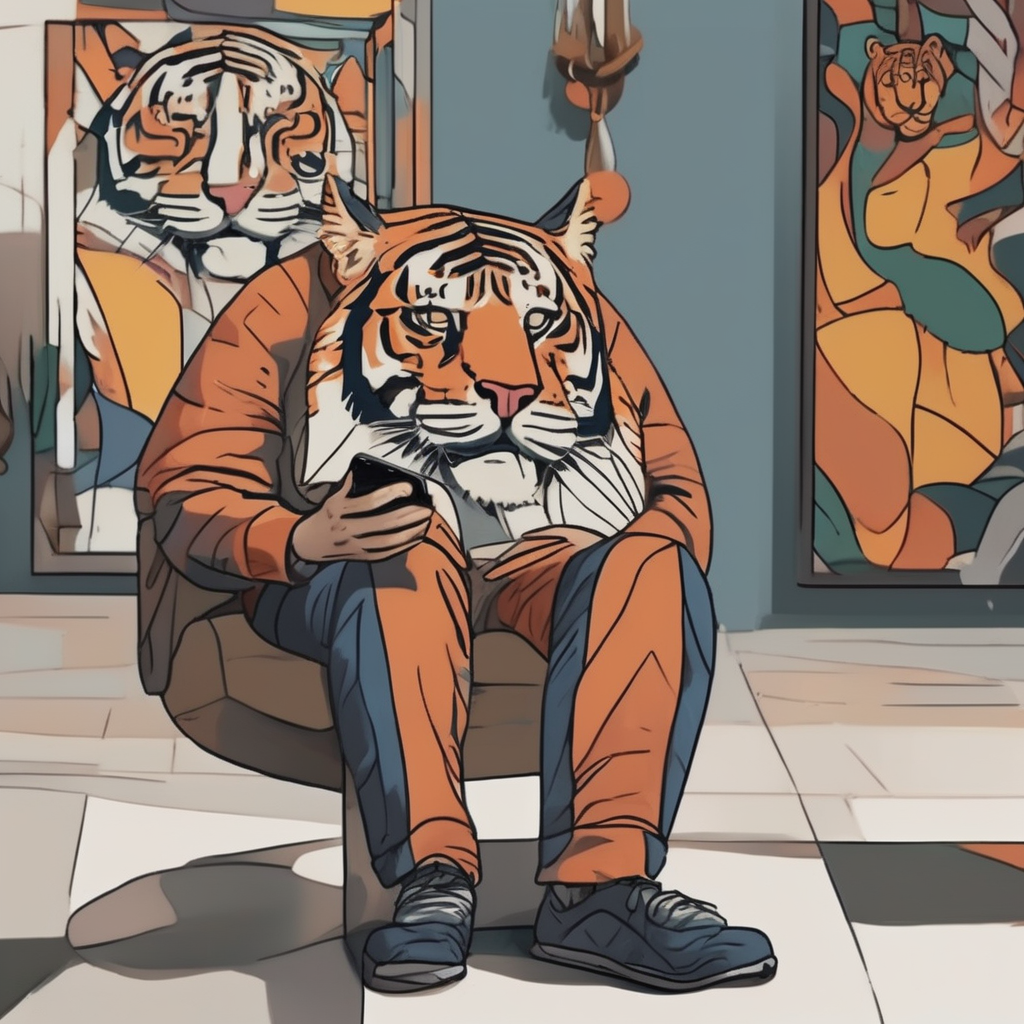

In [49]:
view_s3_file(text)